# EGM722 - Week 5 Practical: Vector and raster operations using python

## Overview

Up to now, we have worked with either vector data or raster data, but we haven't really used them together. In this week's practical, we'll learn how we can combine these two data types, and see some examples of different analyses, such as zonal statistics or sampling raster data, that we can automate using python.

## Objectives
-  learn how to use `rasterstats` to perform zonal statistics
-  learn how to handle exceptions using try...except
-  rasterize polygon data using `rasterio`
-  learn how to mask and select (index) rasters using vector data
-  see additional plotting examples using matplotlib

## Data provided

In the data\_files folder, you should have the following:
-  LCM2015_Aggregate_100m.tif
-  NI_DEM.tif


## 1. Getting started

In this practical, we'll look at a number of different GIS tasks related to working with both raster and vector data in python, as well as a few different python and programming concepts. To get started, run the cell below.

In [1]:
%matplotlib notebook

import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

plt.rcParams.update({'font.size': 22}) # update the font size for our plots to be size 22

## 2. Zonal statistics
In GIS, [_zonal statistics_](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-zonal-statistics-works.htm) is a process whereby you calculate statistics for the pixels of a raster in different groups, or zones, defined by properties in another dataset. In this example, we're going to use the Northern Ireland County border dataset from Week 2, along with a re-classified version of the Northern Ireland [Land Cover Map](https://catalogue.ceh.ac.uk/documents/47f053a0-e34f-4534-a843-76f0a0998a2f) 2015[<sup id="fn1-back">1</sup>](#fn1 "footnote 1").

The Land Cover Map tells, for each pixel, what type of land cover is associated with a location - that is, whether it's woodland (and what kind of woodland), grassland, urban or built-up areas, and so on. For our re-classified version of the dataset, we're working with the aggregate class data, re-sampled to 100m resolution from the original 25m resolution.

The raster data type is _unsigned integer_ with a _bitdepth_ of 8 bits - that is, it has a range of possible values from 0 to 255. Even though it has this range of possible values, we only use 10 (11) of them:

| Raster value | Aggregate class name       |
| :------------|:---------------------------|
| 0            | No Data                    |
| 1            | Broadleaf woodland         |
| 2            | Coniferous woodland        |
| 3            | Arable                     |
| 4            | Improved grassland         |
| 5            | Semi-natural grassland     |
| 6            | Mountain, heath, bog       |
| 7            | Saltwater                  |
| 8            | Freshwater                 |
| 9            | Coastal                    |
| 10           | Built-up areas and gardens |

In this part of the practical, we'll try to work out the percentage of the entire country that is covered by each of these different landcovers, as well as each of the different counties. To start, we'll load the `LCM2015_Aggregate_100m.tif` raster, as well as the counties shapefile from Week 2:

In [2]:
# open the land cover raster and read the data
with rio.open('data_files/LCM2015_Aggregate_100m.tif') as dataset:
    xmin, ymin, xmax, ymax = dataset.bounds 
    crs = dataset.crs
    landcover = dataset.read(1)
    affine_tfm = dataset.transform

# now, load the county dataset from the week 2 folder
counties = gpd.read_file('../Week2/data_files/Counties.shp').to_crs(crs)

Next, we'll define a function that takes an array, and returns a __dict__ object containing the count (number of pixels) for each of the unique values in the array:

```python
def count_unique(array, nodata=0):
    '''
    Count the unique elements of an array.

    :param array: Input array
    :param nodata: nodata value to ignore in the counting
    
    :returns count_dict: a dictionary of unique values and counts
    '''
    count_dict = {}
    for val in np.unique(array):
        if val == nodata:
            continue
        count_dict[str(val)] = np.count_nonzero(array == val)
    return count_dict
```

Here, we have two input parameters: the first, `array`, is our array (or raster data). The next, `nodata`, is the value of the array that we should ignore. We then define an empty __dict__ (`count_dict = {}`). 

With [`numpy.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), we get an array containing the unique values of the input array. Note that this works for data like this raster, where we have a limited number of pre-defined values. For something like a digital elevation model, which represents continuous floating-point values, we wouldn't want to use this approach to bin the data.

Next, for each of the different unique values `val`, we find all of the locations in `array` that have that value (`array == val`). Note that this is actually a boolean array, with values of either `True` where `array == val`, and `False` where `array != val`. [`numpy.count_nonzero()`](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html) the counts the number of non-zero (in this case, `True`) values in the array - that is, this:

```python
np.count_nonzero(array == val)
```

tells us the number of pixels in `array` that are equal to `val`. We then assign this to our dictionary with a key that is a __str__ representation of the value, before returning our `count_dict` variable at the end of the function.

Run the cell below to define the function and run it on our `landcover` raster.

In [3]:
def count_unique(array, nodata=0):
    '''
    Count the unique elements of an array.

    :param array: Input array
    :param nodata: nodata value to ignore in the counting
    
    :returns count_dict: a dictionary of unique values and counts
    '''
    count_dict = {}
    for val in np.unique(array):
        if val == nodata:
            continue
        count_dict[str(val)] = np.count_nonzero(array == val)
    return count_dict

unique_landcover = count_unique(landcover)
print(unique_landcover)

{'1': 40311, '2': 73386, '3': 90736, '4': 834512, '5': 75980, '6': 179942, '7': 16991, '8': 60877, '9': 14085, '10': 56598}


So this provides us with a __dict__ object with keys corresponding to each of the unique values (1-10).

<span style="color:#009fdf;font-size:1.1em;font-weight:bold">Can you work out the percentage area of Northern Ireland that is covered by each of the 10 landcover classes?</span>

In [16]:
sumLandcover = sum(unique_landcover.values())

for key, value in unique_landcover.items():
    print("{} : {:.2f}%".format(key, value / sumLandcover * 100))

1 : 2.79%
2 : 5.08%
3 : 6.29%
4 : 57.81%
5 : 5.26%
6 : 12.47%
7 : 1.18%
8 : 4.22%
9 : 0.98%
10 : 3.92%


In the following cell, we use [`rasterstats.zonal_stats()`](https://pythonhosted.org/rasterstats/manual.html#zonal-statistics) with our `counties` and `landcover` datasets to do the same exercise as above (counting unique pixel values). Rather than counting the pixels in the entire raster, however, we want to count the number of pixels with each land cover value that fall within a specific area defined by the features in the  `counties` dataset:

In [17]:
county_stats = zonal_stats(counties, landcover, affine=affine_tfm, categorical=True, nodata=0)

print(county_stats[0])

{1: 7221, 2: 20069, 3: 6178, 4: 204078, 5: 17176, 6: 54540, 8: 11464, 9: 1, 10: 5649}


## 3. The zip built-in

This isn't a very readable result, though. If we want to interpret the results for each county, we have to know what land cover name corresponds to each of the values in the raster. One way that we could do this is by writing a function that re-names each of the keys in the __dict__. This example shows one way we could do this: the function takes the original __dict__ object (_dict_in_), as well as a list of the 'old' keys (_old_names_), and the corresponding 'new' keys (_new_names_).

In [18]:
def rename_dict(dict_in, old_names, new_names):
    '''
    Rename the keys of a dictionary, given a list of old and new keynames

    :param dict_in: the dictionary to rename
    :param old_names: a list of old keys
    :param new_names: a list of new key names
    
    :returns dict_out: a dictionary with the keys re-named
    '''
    dict_out = {}
    for new, old in zip(new_names, old_names):
        dict_out[new] = dict_in[old]

    return dict_out

For this function, we're also making use of the built-in function `zip()` ([documentation](https://docs.python.org/3.8/library/functions.html#zip)). In Python 3, `zip()` returns an __iterator__ object that combines elements from each of the iterable objects passed as arguments. As an example:

In [19]:
x = [1, 2, 3, 4]
y = ['a', 'b', 'c', 'd']

list(zip(x, y))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

So, with `zip(x, y)`, each of the elements of `x` is paired with the corresponding element from `y`. If `x` and `y` are different lengths, `zip(x, y)` will only use up to the shorter of the two:

In [20]:
x = [1, 2, 3]

list(zip(x, y))

[(1, 'a'), (2, 'b'), (3, 'c')]

Let's see what happens when we run our function `rename_dict()` using the stats for our first county (County Tyrone - remember that the output from zonal_stats will have correspond to the rows of our input vector data):

In [21]:
old_names = [float(i) for i in range(1, 11)]
new_names = ['Broadleaf woodland', 'Coniferous woodland', 'Arable', 'Improved grassland',
             'Semi-natural grassland', 'Mountain, heath, bog', 'Saltwater', 'Freshwater',
             'Coastal', 'Built-up areas and gardens']

rename_dict(county_stats[0], old_names, new_names)

KeyError: 7.0

Have a look at the _keys_ for `county_stats` - you should notice that there are no pixels corresponding to landcover class 7 (Saltwater), which makes sense given that County Tyrone is an inland county:

In [22]:
print(county_stats[0].keys())
print(county_stats[0])

dict_keys([1, 2, 3, 4, 5, 6, 8, 9, 10])
{1: 7221, 2: 20069, 3: 6178, 4: 204078, 5: 17176, 6: 54540, 8: 11464, 9: 1, 10: 5649}


To run this for each of our counties, we could run some checks to make sure that we only try to access keys that exist in `dict_in`. For example, we could add an `if` statement to the function:

```python
def rename_dict(dict_in, old_names, new_names):
    dict_out = {}
    for new, old in zip(new_names, old_names)
        if old in dict_in.keys():
            dict_out[new] = dict_in[old]
        else:
            continue
    return dict_out
```

But, this is also an example of an exception that isn't necessarily something that requires us to stop executing our program. We don't expect each landcover type to be present in each county, so we don't want our program to stop as soon as it finds out that one of the counties doesn't have a particular landcover type.

## 4. Handling Exceptions with try ... except
Python provides a way to handle these kind of exceptions: the [try...except](https://realpython.com/python-exceptions/#the-try-and-except-block-handling-exceptions) block:
```python

try:
    # run some code
except:
    # run this if the try block causes an exception
```

In general, it's [not recommended](https://www.python.org/dev/peps/pep-0008/#programming-recommendations) to just have a bare `except:` clause, as this will make it harder to interrupt a program. In our specific case, we only want the interpreter to ignore `KeyError` exceptions - if there are other problems, we still need to know about those:

In [23]:
def rename_dict(dict_in, old_names, new_names):
    '''
    Rename the keys of a dictionary, given a list of old and new keynames

    :param dict_in: the dictionary to rename
    :param old_names: a list of old keys
    :param new_names: a list of new key names
    
    :returns dict_out: a dictionary with the keys re-named
    '''
    dict_out = {}
    for new, old in zip(new_names, old_names):
        try:
            dict_out[new] = dict_in[old]
        except KeyError:
            continue
    return dict_out

Notice how for each pair of names, we try to assign the value corresponding to `old` in `dict_in`. If `old` is not a valid key for `dict_in`, we just move onto the next one. Now, let's run this new function on `county_stats[0]` again:

In [24]:
rename_dict(county_stats[0], old_names, new_names)

{'Broadleaf woodland': 7221,
 'Coniferous woodland': 20069,
 'Arable': 6178,
 'Improved grassland': 204078,
 'Semi-natural grassland': 17176,
 'Mountain, heath, bog': 54540,
 'Freshwater': 11464,
 'Coastal': 1,
 'Built-up areas and gardens': 5649}

We'll do one last thing before moving on here. Just like with the __dict__ outputs of `zonal_stats()`, the __list__ of __dict__ objects isn't very readable. Let's create a new __dict__ object that takes the county names as keys, and returns the re-named __dict__ objects for each:

In [25]:
renamed_list = [rename_dict(d, old_names, new_names) for d in county_stats] # create a list of renamed dict objects
nice_names = [n.title() for n in counties.CountyName]
stats_dict = dict(zip(nice_names, renamed_list))

print(stats_dict['Tyrone'])
print(stats_dict['Antrim'])

{'Broadleaf woodland': 7221, 'Coniferous woodland': 20069, 'Arable': 6178, 'Improved grassland': 204078, 'Semi-natural grassland': 17176, 'Mountain, heath, bog': 54540, 'Freshwater': 11464, 'Coastal': 1, 'Built-up areas and gardens': 5649}
{'Broadleaf woodland': 6874, 'Coniferous woodland': 12401, 'Arable': 12766, 'Improved grassland': 173631, 'Semi-natural grassland': 15442, 'Mountain, heath, bog': 47318, 'Saltwater': 168, 'Freshwater': 20710, 'Coastal': 1603, 'Built-up areas and gardens': 18744}


Depending on how we're using the data, it might be easier to keep the output of `zonal_stats()` as-is, rather than using these long, complicated keys. For visualization and readability purposes, though, it helps to be able to easily and quickly understand what the outputs actually represent.

<span style="color:#009fdf;font-size:1.1em;font-weight:bold">What is the total area (in km<sup>2</sup>) covered by "Mountain, heath, bog" in County Down?</span>

In [31]:
print(stats_dict['Down'])

{'Broadleaf woodland': 7933, 'Coniferous woodland': 3406, 'Arable': 46974, 'Improved grassland': 140440, 'Semi-natural grassland': 11337, 'Mountain, heath, bog': 18795, 'Saltwater': 190, 'Freshwater': 1326, 'Coastal': 2446, 'Built-up areas and gardens': 16185}


## 5. Rasterizing vector data using rasterio
`rasterstats` provides a nice tool for quickly and easily extracting zonal statistics from a raster using vector data. Sometimes, though, we might want to _rasterize_ our vector data - for example, in order to mask our raster data, or to be able to select pixels. To do this, we can use the [`rasterio.features`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html) module:

In [32]:
import rasterio.features # we have imported rasterio as rio, so this will be rio.features (and rasterio.features)

`rasterio.features`has a number of different methods, but the one we are interested in here is `rasterize()`:

```
rio.features.rasterize(
    shapes,
    out_shape=None,
    fill=0,
    out=None,
    transform=Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0),
    all_touched=False,
    merge_alg=<MergeAlg.replace: 'REPLACE'>,
    default_value=1,
    dtype=None,
)
Docstring:
Return an image array with input geometries burned in.

Warnings will be raised for any invalid or empty geometries, and
an exception will be raised if there are no valid shapes
to rasterize.

Parameters
----------
shapes : iterable of (`geometry`, `value`) pairs or iterable over
    geometries. The `geometry` can either be an object that
    implements the geo interface or GeoJSON-like object. If no
    `value` is provided the `default_value` will be used. If `value`
    is `None` the `fill` value will be used.
out_shape : tuple or list with 2 integers
    Shape of output numpy ndarray.
fill : int or float, optional
    Used as fill value for all areas not covered by input
    geometries.
...
```

Here, we pass an __iterable__ (__list__, __tuple__, __array__, etc.) that contains (__geometry__, __value__) pairs. __value__ determines the pixel values in the output raster that the __geometry__ overlaps. If we don't provide a __value__, it takes the `default_value` or the `fill` value.

So, to create a rasterized version of our county outlines, we could do the following:

```python
shapes = list(zip(counties['geometry'], counties['COUNTY_ID']))

county_mask = rio.features.rasterize(shapes=shapes, fill=0, 
                                     out_shape=landcover.shape, transform=affine_tfm)
```

The first line uses `zip()` and `list()` to create a list of (__geometry__, __value__) pairs, and the second line actually creates the rasterized array, `county_mask`. Note that in the call to `rasterio.features.rasterize()`, we have to set the output shape (`out_shape`) of the raster, as well as the `transform` - that is, how we go from pixel coordinates in the array to real-world coordinates. Since we want to use this rasterized output with our `landcover`, we use the `shape` of the `landcover` raster, as well as its `transform` (`affine_tfm`) - that way, the outputs will line up as we expect. Run the cell below to see what the output looks like:

<IPython.core.display.Javascript object>


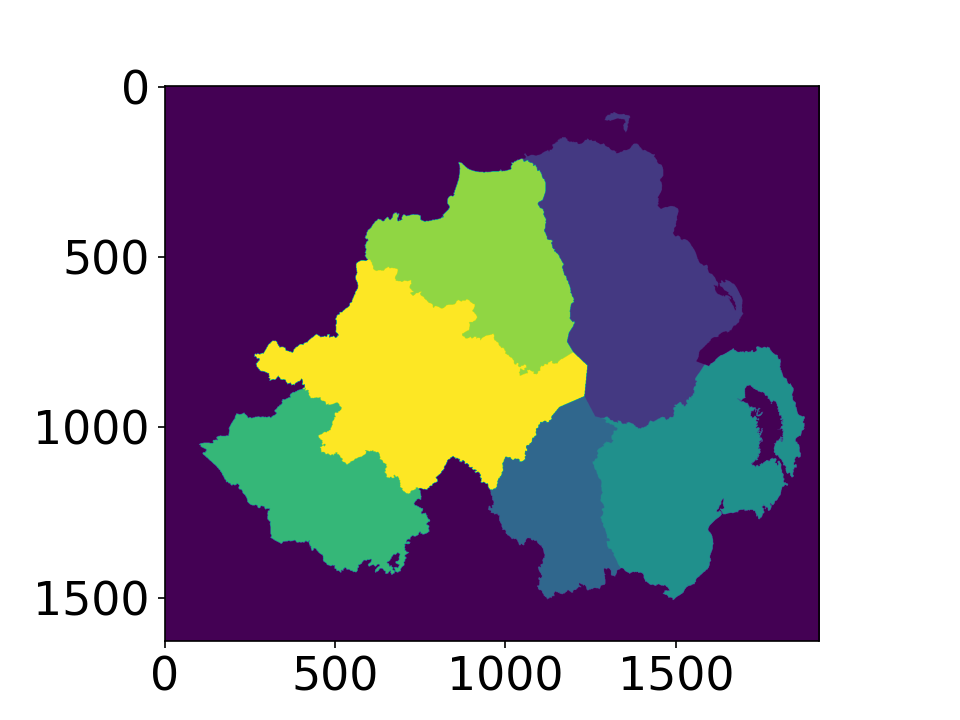

In [33]:
shapes = list(zip(counties['geometry'], counties['COUNTY_ID']))

county_mask = rio.features.rasterize(shapes=shapes, fill=0,
                                     out_shape=landcover.shape, transform=affine_tfm)
plt.figure()
plt.imshow(county_mask) # visualize the rasterized output

As you can see, this provides us with an __array__ whose values correspond to the `COUNTY_ID` of the county feature at that location (check the `counties` __GeoDataFrame__ again to see which county corresponds to which ID). In the next section, we'll see how we can use arrays like this to investigate our data further.

## 6. Masking and indexing rasters
So far, we've seen how we can index an array (or a list, a tuple, ...) using simple indexing (e.g., `myList[0]`) or _slicing_ (e.g., `myList[2:4]`). `numpy` arrays, however, can [actually be indexed](https://numpy.org/doc/stable/reference/arrays.indexing.html) using other arrays of type `bool` (the elements of the array are boolean (`True`/`False`) values). In this section, we'll see how we can use this, along with our rasterized vectors, to select and investigate values from a raster using boolean indexing.

To start, we'll open our dem raster - note that this raster has the same georeferencing information as our landcover raster, so we don't have to load all of that information, just the raster band:

In [34]:
with rio.open('data_files/NI_DEM.tif') as dataset:
    dem = dataset.read(1)

From the previous section, we have an array with values corresponding each of the counties of Northern Ireland. Using `numpy`, we can use this array to select elements of other rasters by creating a _mask_, or a boolean array - that is, an array with values of `True` and `False`. For example, we can create a mask corresponding to County Antrim (`COUNTY_ID=1`) like this:

```python
county_antrim = county_mask == 1
```
Let's see what this mask looks like:

<IPython.core.display.Javascript object>


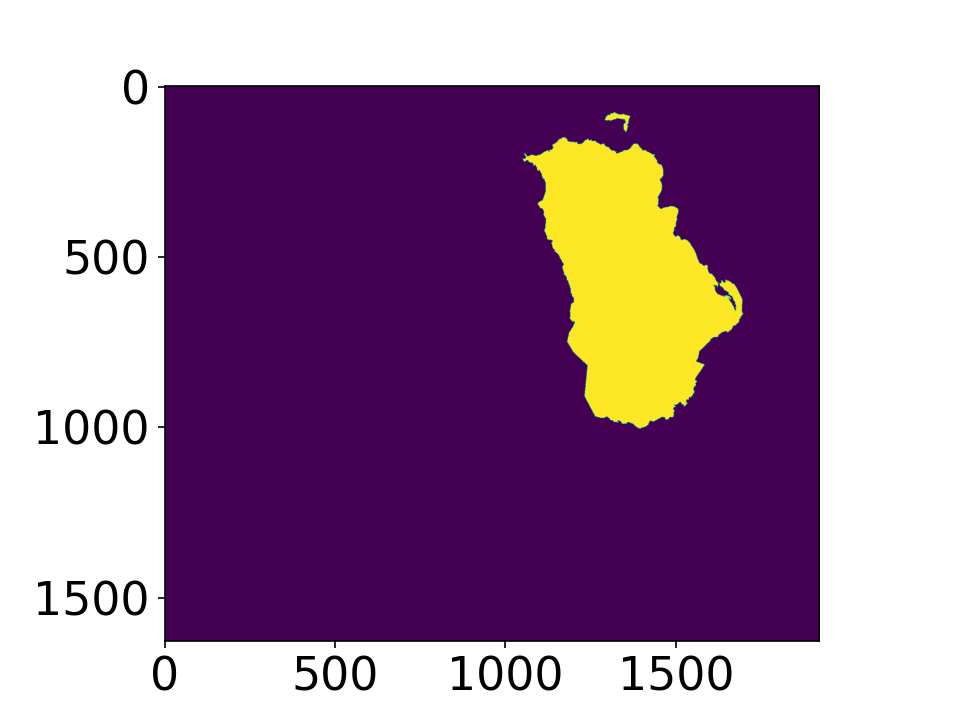

In [35]:
county_antrim = county_mask == 1

plt.figure()
plt.imshow(county_antrim)

We can also combine expressions using functions like [`np.logical_and()`](https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html) or [`np.logical_or()`](https://numpy.org/doc/stable/reference/generated/numpy.logical_or.html). If we wanted to create a mask corresponding to both County Antrim and County Down, we could do the following:

<IPython.core.display.Javascript object>


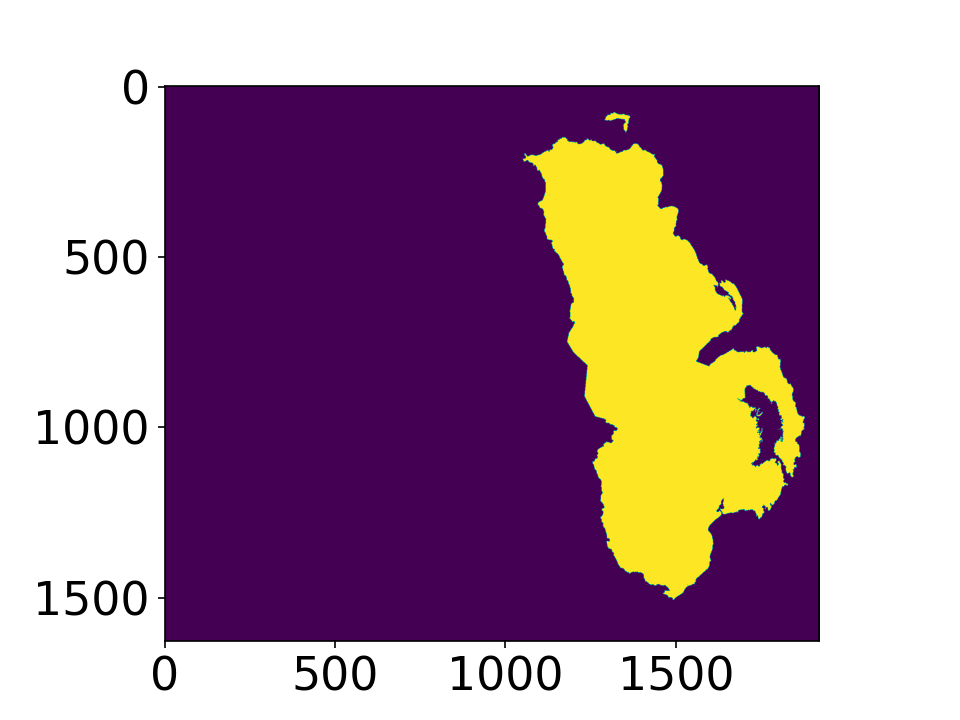

In [36]:
antrim_and_down = np.logical_or(county_mask == 3, county_mask == 1)

plt.figure()
plt.imshow(antrim_and_down)

We could then find the mean elevation of these two counties by indexing, or selecting, pixels from `dem` using our mask:

In [37]:
ad_elevation = dem[antrim_and_down]
print('Mean elevation: {:.2f} m'.format(ad_elevation.mean()))

Mean elevation: 112.61 m


Now let's say we wanted to investigate the two types of woodland we have, broadleaf and conifer. One thing we might want to look at is the area-elevation distribution of each type. To do this, we first have to select the pixels from the DEM that correspond to the broadleaf woodlands, and all of the pixels corresponding to conifer woodlands:

In [38]:
broad_els = dem[landcover == 1] # get all dem values where landcover = 1
conif_els = dem[landcover == 2] # get all dem values where landcover = 2

Now, we have two different arrays, `broad_els` and `conif_els`, each corresponding to the DEM pixel values of each landcover type. We can plot a histogram of these arrays using [`plt.hist()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html), but this will only tell us the number of pixels - for the area-elevation distribution, we have to convert the pixel counts into areas by multiplying with the pixel area (100 m x 100 m).

First, though, we can use `numpy.histogram()`, along with an array representing our elevation bins, to produce a count of the number of pixels with an elevation that falls within each bin. Let's try elevations ranging from 0 to 600 meters, with a spacing of 5 meters:

In [39]:
el_bins = np.arange(0, 600, 5) # create an array of values ranging from 0 to 600, spaced by 5.

broad_count, _ = np.histogram(broad_els, el_bins) # bin the broadleaf elevations using the elevation bins
conif_count, _ = np.histogram(conif_els, el_bins) # bin the conifer elevations using the elevation bins

broad_area = broad_count * 100 * 100 # convert the pixel counts to an area by multipling by the pixel size in x, y
conif_area = conif_count * 100 * 100

Finally, we can plot the area-elevation distribution for each land cover type using [`matplotlib.pyplot.bar()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html):

<IPython.core.display.Javascript object>


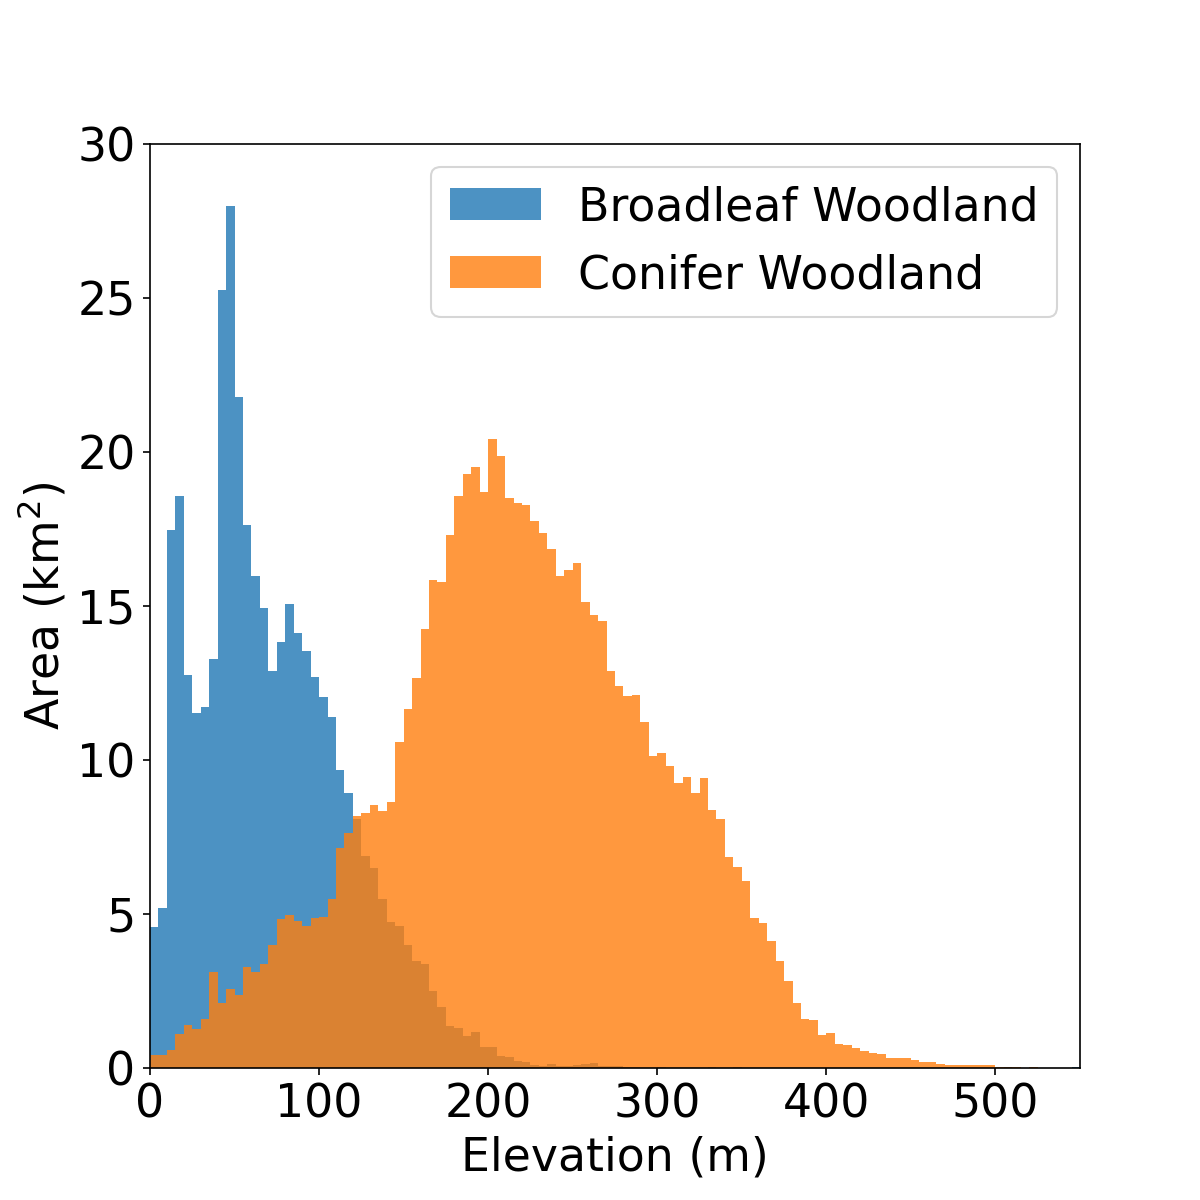

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) # create a new figure and axes object

# plot the area-elevation distributions using matplotlib.pyplot.bar(), converting from sq m to sq km:
_ = ax.bar(el_bins[:-1], broad_area / 1e6, align='edge', width=5, alpha=0.8, label='Broadleaf Woodland')
_ = ax.bar(el_bins[:-1], conif_area / 1e6, align='edge', width=5, alpha=0.8, label='Conifer Woodland')

ax.set_xlim(0, 550) # set the x limits of the plot
ax.set_ylim(0, 30) # set the y limits of the plot

ax.set_xlabel('Elevation (m)') # add an x label
ax.set_ylabel('Area (km$^2$)') # add a y label
ax.legend() # add a legend

From this, we can clearly see that Conifer woodlands tend to be found at much higher elevations than Broadleaf woodlands, and at a much larger range of elevations (0-500 m, compared to 0-250 m or so). With these samples (`broad_els`, `conif_els`), we can also calculate statistics for each of these samples using `numpy` functions such as `np.mean()`, `np.median()`, `np.std()`, and so on.

<span style="color:#009fdf;font-size:1.1em;font-weight:bold">Of the 10 different landcover types shown here, which one has the highest mean elevation? What about the largest spread in elevation values?</span>

## Next steps

That's all for this practical. In lieu of an an additional exercise this week, spend some time working on your project - are there concepts or examples from this practical that you can incorporate into your project?

### Footnotes
[<sup id="fn1">1</sup>](#fn1-back)Rowland, C.S.; Morton, R.D.; Carrasco, L.; McShane, G.; O'Neil, A.W.; Wood, C.M. (2017). Land Cover Map 2015 (25m raster, N. Ireland). NERC Environmental Information Data Centre. [doi:10.5285/47f053a0-e34f-4534-a843-76f0a0998a2f](https://doi.org/10.5285/47f053a0-e34f-4534-a843-76f0a0998a2f)</span>